# Shipping data: binary classification with decision tree

This notebook shows a neet way to perform model selection for decision trees in binary classification problems.
It is divided in the following sections:
- A. Decision Tree (DT): Summary
- B. Data inspection & preparation
- C. Model selection
- D. Model predictions & interpretation

## A. Decision Tree (DT): Summary
Decision Tree is a supervised ML method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. 
In simple terms, a tree is composed by decision nodes specifying the condition (or criterion) leaving the lowest entropy in leaf nodes. It learns by maximizing information gain (goal: obtaining pure leaf nodes) (pure node: entropy = 0).
The model looks at every possible split to find the highest information gain.

### Advantages:
- Simple to understand and to interpret. Trees can be visualized.
- Requires little data preparation (e.g., no need for normalization), but does not support handling of missing values.
- The cost of using the tree (i.e., predicting data) is logarithmic in the number of data points used to train the tree.
- Able to handle both numerical and categorical data. 
- Able to handle multi-classification problems.
- White box: decision nodes (conditions) are transparent.

### Disadvantages:
- Often overfit
- Often unstable 
- Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree
- Chance to get stuck in local optimum: every splitting depends on prior splitting

## B. Data inspection & preparation:

The e-commerce dataset is composed of 10999 purcheses (rows), 11 features, and a binary target (on time / not on time).
Target represents whether a product has been delivered on time (1) or not (0).
Features include information regarding customers, product, and shipment.
The dataset can be downloaded from Kaggle: https://www.kaggle.com/datasets/prachi13/customer-analytics

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv('eCommerce_shipping_data.csv')
data = dataset.copy()
data.tail()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
10994,10995,A,Ship,4,1,252,5,medium,F,1,1538,1
10995,10996,B,Ship,4,1,232,5,medium,F,6,1247,0
10996,10997,C,Ship,5,4,242,5,low,F,4,1155,0
10997,10998,F,Ship,5,2,223,6,medium,M,2,1210,0
10998,10999,D,Ship,2,5,155,5,low,F,6,1639,0


The dataset is composed of 10999 purcheses (rows), 11 features, and a binary target (on time / not on time).
Let's plot some descriptives.

As described above, DTs require very little data handling. The only things we need to make sure of are:
1. target is equally represented in the two classes. This is because a training set consisting of different numbers of representatives from either class may result in a classifier that is biased towards the majority class. When applied to a test set that is similarly imbalanced, this classifier yields an optimistic accuracy estimate. 
2. categorical variables are forced to numeric.

Let's look at the distribution of the target first.

### ID:

In [3]:
usr = data['ID'].value_counts()
print("Purchasing decisions come from ", len(data['ID'].unique()), " unique customers for ",
      len(data), " purchase orders")

Purchasing decisions come from  10999  unique customers for  10999  purchase orders


ID is useless. We will remove it from the dataset.

### Warehouse block:

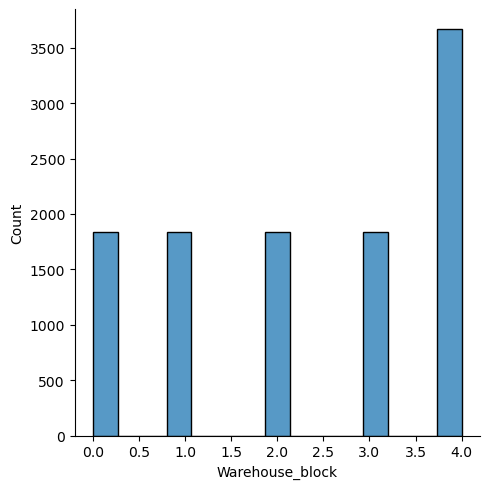

In [4]:
#data['Warehouse_block'].unique()        # A,B,C,D,F
data['Warehouse_block'].replace(['A','B','C','D','F'],
                               [0,1,2,3,4], inplace=True)
sns.displot(data, x="Warehouse_block")

### Mode of shipment

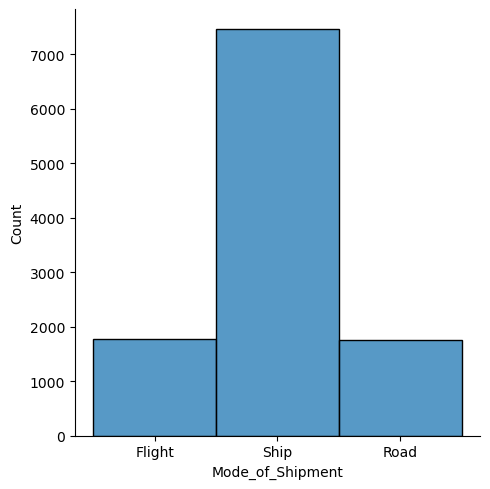

In [5]:
#data['Mode_of_Shipment'].unique()        # 'Flight', 'Ship', 'Road'
sns.displot(data, x="Mode_of_Shipment")
data['Mode_of_Shipment'].replace(['Flight', 'Ship', 'Road'],
                               [0,1,2], inplace=True)

### Customer care calls:

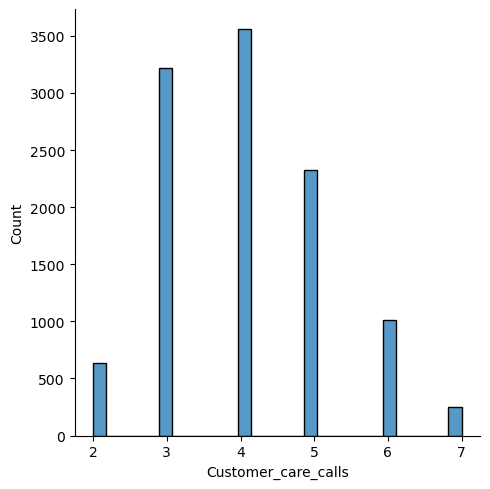

In [6]:
# data['Customer_care_calls'].unique()        # 4, 2, 3, 5, 6, 7
sns.displot(data, x="Customer_care_calls")

### Customer rating:

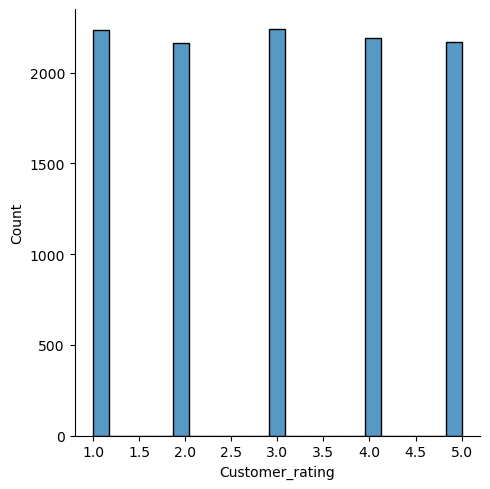

In [7]:
#data['Customer_rating'].unique()            # 1, 2, 3, 4, 5
sns.displot(data, x="Customer_rating")

### Cost of the product:

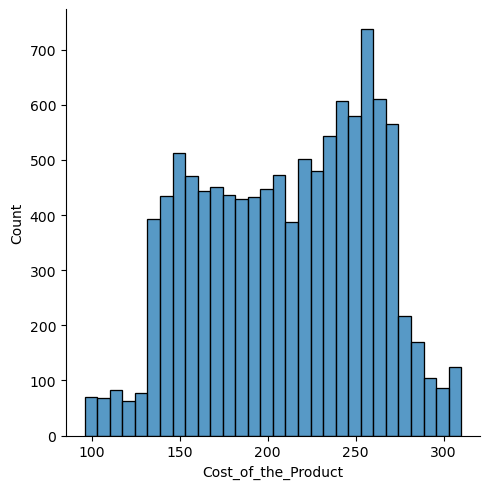

In [8]:
sns.displot(data, x="Cost_of_the_Product")

### Prior purchases:

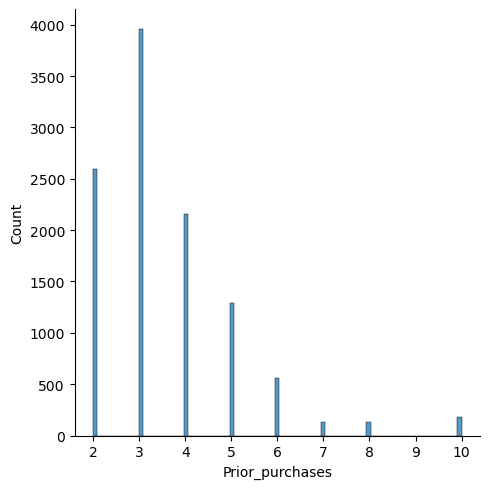

In [9]:
sns.displot(data, x="Prior_purchases")

### Product importance:

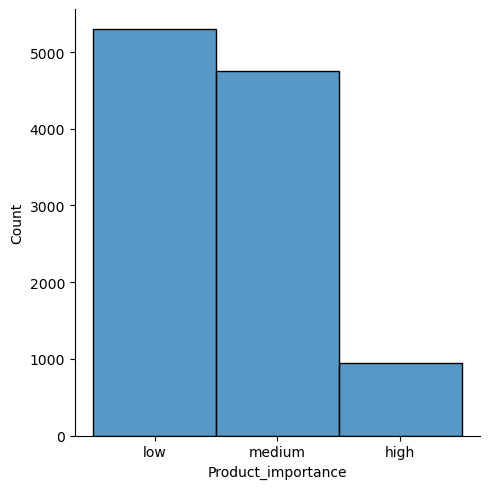

In [10]:
#data['Product_importance'].unique()        # 'low', 'medium', 'high'
sns.displot(data, x="Product_importance")
data['Product_importance'].replace(['low', 'medium', 'high'],
                               [0,1,2], inplace=True)

### Gender:

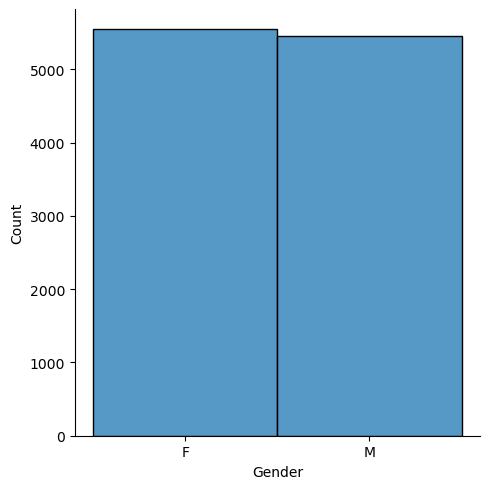

In [11]:
#data['Gender'].unique()        # 'F', 'M'
sns.displot(data, x="Gender")
data['Gender'].replace(['F', 'M'],
                               [0,1], inplace=True)

### Discount offered:

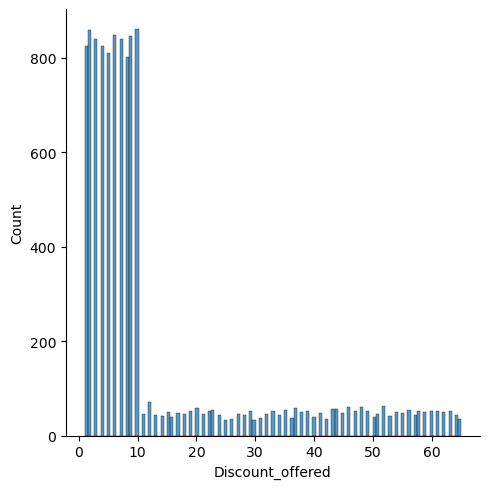

In [12]:
sns.displot(data, x="Discount_offered")

### Weight in gms:

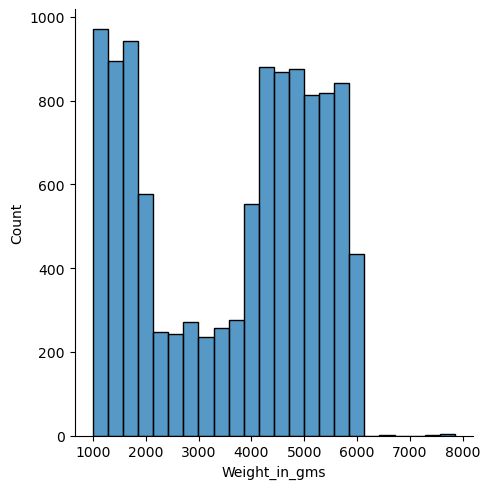

In [13]:
sns.displot(data, x="Weight_in_gms")

### Reached on time [target]:

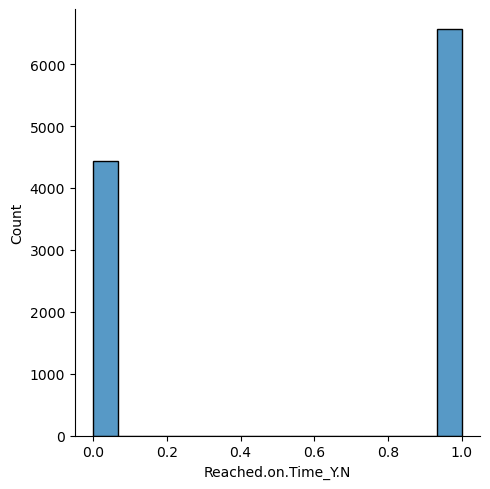

In [14]:
sns.displot(data, x="Reached.on.Time_Y.N")

## C. Model selection
As mentioned, DTs require very little data preparation (e.g., we will not normalize our features to keep them 'meaningful'). DTs can handle both categorical and numerical variables. However, we had to abusively encode our categorical features as integers. We also remove the meaningless 'ID' when splitting the data into features and target.

Below, we evaluate the effect of 3 factors on the AUC metric (a good metric for binary classification problems):

### 1. Balancing cases:
Imbalanced data is problematic for CTs (too). There is a slight imbalance in our data, which might be problematic. Let's fix this by oversampling our data (& using balanced accuracy metrics).
First, we split the data (now only numeric, and without ID) into features and target.
Then we use SMOTE to oversample the data.
We keep both datasets for comparison.

### 2. Splitting criterion:
Sklearn's DecisionTreeClassifier accepts both gini and entropy criteria. They are slightly different measures of information (gain). Computationally, entropy is more complex since it makes use of logarithms and consequently, the calculation of the Gini Index will be faster.

### 3. Depth of the tree:
Among the parameters of sklearn's DecisionTreeClassifier, arguably the most important is 'max_depth', specifying the maximum depth of the tree. Without limiting the size of the tree, the model will very often overfit. Further, complex trees reduce the possibility to spell out the sequence of decision nodes, thus loosing one of the main advantages of DTs. We will explore the effect of varying tree depth.

In [15]:
X = data.iloc[:, 1:-1].values    # removing ID
Y = data.iloc[:, -1].values.reshape(-1,1)

from imblearn.over_sampling import SMOTE, ADASYN
import random
random.seed(99)     # for reproducibility (possibly not needed)
X_resampled, Y_resampled = SMOTE().fit_resample(X, Y)
print("Length of new dataset = ", len(X_resampled))
print("Proportion on time =", np.count_nonzero(Y_resampled == 1) / len(Y_resampled) * 100, "%")

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=0)
X_train_RS, X_test_RS, Y_train_RS, Y_test_RS = train_test_split(X_resampled, Y_resampled, test_size=.2, random_state=0)

The function below is used to evaluate the three factors described above.

In [198]:
def fit_DT_predict(Xtr,Ytr,Xte,Yte,metric,max_tree_depths):
        
    train_results = []
    test_results = []
    
    for depth in max_tree_depths:
        if metric == 'gini':
            dt = DecisionTreeClassifier(max_depth=depth, random_state=0)
        elif metric == 'entropy':
            dt = DecisionTreeClassifier(max_depth=depth, criterion='entropy', random_state=0)
        
        dt.fit(Xtr, Ytr)
        train_pred = dt.predict(Xtr)   
        false_positive_rate, true_positive_rate, thresholds = roc_curve(Ytr, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)

        # Add auc score to previous train results
        train_results.append(roc_auc)   
        test_pred = dt.predict(Xte)   
        false_positive_rate, true_positive_rate, thresholds = roc_curve(Yte, test_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)

        # Add auc score to previous test results
        test_results.append(roc_auc)
    
    return train_results, test_results

In [199]:
tree_depths = np.linspace(1, 30, 30, endpoint=True)

train_results_gini, test_results_gini = fit_DT_predict(X_train,Y_train,X_test,Y_test,'gini',tree_depths)
train_results_gini_RS, test_results_gini_RS = fit_DT_predict(X_train_RS,Y_train_RS,X_test_RS,Y_test_RS,'gini',tree_depths)
train_results_entropy, test_results_entropy = fit_DT_predict(X_train,Y_train,X_test,Y_test,'entropy',tree_depths)
train_results_entropy_RS, test_results_entropy_RS = fit_DT_predict(X_train_RS,Y_train_RS,X_test_RS,Y_test_RS,'entropy',tree_depths)

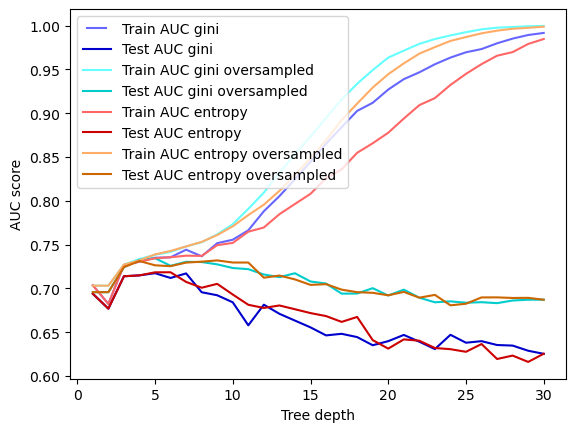

In [205]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(tree_depths, train_results_gini, color=(102/255, 102/255, 1), label="Train AUC gini")
line2, = plt.plot(tree_depths, test_results_gini, color=(0, 0, 204/255), label="Test AUC gini")

line3, = plt.plot(tree_depths, train_results_gini_RS, color=(102/255, 1, 1), label="Train AUC gini oversampled")
line4, = plt.plot(tree_depths, test_results_gini_RS, color=(0, 204/255, 204/255), label="Test AUC gini oversampled")

line5, = plt.plot(tree_depths, train_results_entropy, color=(1, 102/255, 102/255), label="Train AUC entropy")
line6, = plt.plot(tree_depths, test_results_entropy, color=(204/255, 0, 0), label="Test AUC entropy")

line7, = plt.plot(tree_depths, train_results_entropy_RS, color=(1, 172/255, 102/255), label="Train AUC entropy oversampled")
line8, = plt.plot(tree_depths, test_results_entropy_RS, color=(204/255, 102/255, 0), label="Test AUC entropy oversampled")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=8)})
plt.ylabel('AUC score')

plt.xlabel('Tree depth')
plt.show()
#plt.savefig('model_comparison.png')

We now discuss the effect of the manipulated model features:

1. Balancing cases: not surprisingly, oversampling had a positive impact on test accuracy, by making the predictions more generalizable. In this case, it also improved training accuracy.
2. Splitting criterion: gini overperformed entropy for training accuracy. For test accuracy there is virtually no difference, except maybe at depth = 5. Since entropy is computationally more challenging, it is advised to use gini in this case.
3. Depth of the tree: as can be seen from the diverging patterns of train and test AUC, the model starts to overfit already after depth = 5, demonstrating that highly complex trees are not only difficoult to interpret, but often inaccurate too.

Summing up, the model performing the best predictions, and the one we will choose, is the one trained on the bootstrapped data, using gini criterion, with a depth of 5.

## D. Model predictions & interpretation:

### Most relevant features:

The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.

In [206]:
clf = DecisionTreeClassifier(max_depth = 5, random_state=0)
clf.fit(X_train_RS, Y_train_RS)

feature_names = data.iloc[:, 1:-1].columns
feature_importance = pd.DataFrame(clf.feature_importances_, index = feature_names)
feature_importance

,0
Warehouse_block,0.011921
Mode_of_Shipment,0.000000
Customer_care_calls,0.012690
Customer_rating,0.004569
Cost_of_the_Product,0.018896
Prior_purchases,0.068072
Product_importance,0.012235
Gender,0.003825
Discount_offered,0.796304
Weight_in_gms,0.071488


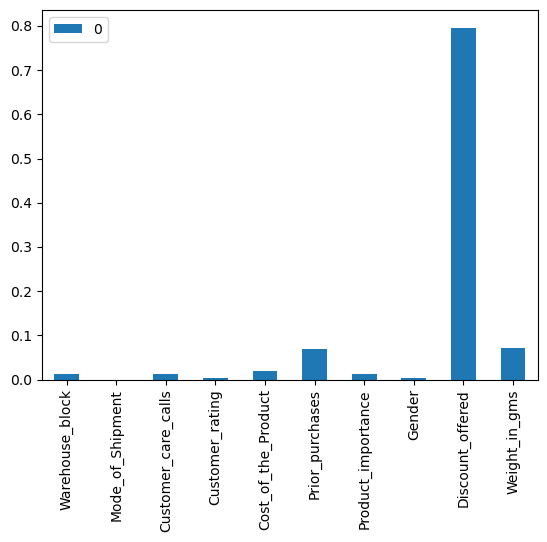

In [211]:
feature_importance.plot.bar()
ax.set_title("Feature importance")
ax.set_ylabel("Gini importance")
fig.tight_layout()

For some reason, discount offered accounts for about 80% of the feature importances, and the remaining 8 features only account for the remaining 20%, with mode of shipment never being used in any decision node.

In [212]:
from sklearn.metrics import classification_report
predictions = clf.predict(X_test_RS)
print(classification_report(Y_test_RS, predictions, target_names=['Not on time','On time']))

              precision    recall  f1-score   support

 Not on time       0.67      0.98      0.79      1346
     On time       0.96      0.49      0.65      1280

    accuracy                           0.74      2626
   macro avg       0.81      0.73      0.72      2626
weighted avg       0.81      0.74      0.72      2626



F1 score is around 74%. However 'on time' recall is just 49%, which may be problematic for some applications.
Let's now visualize the tree

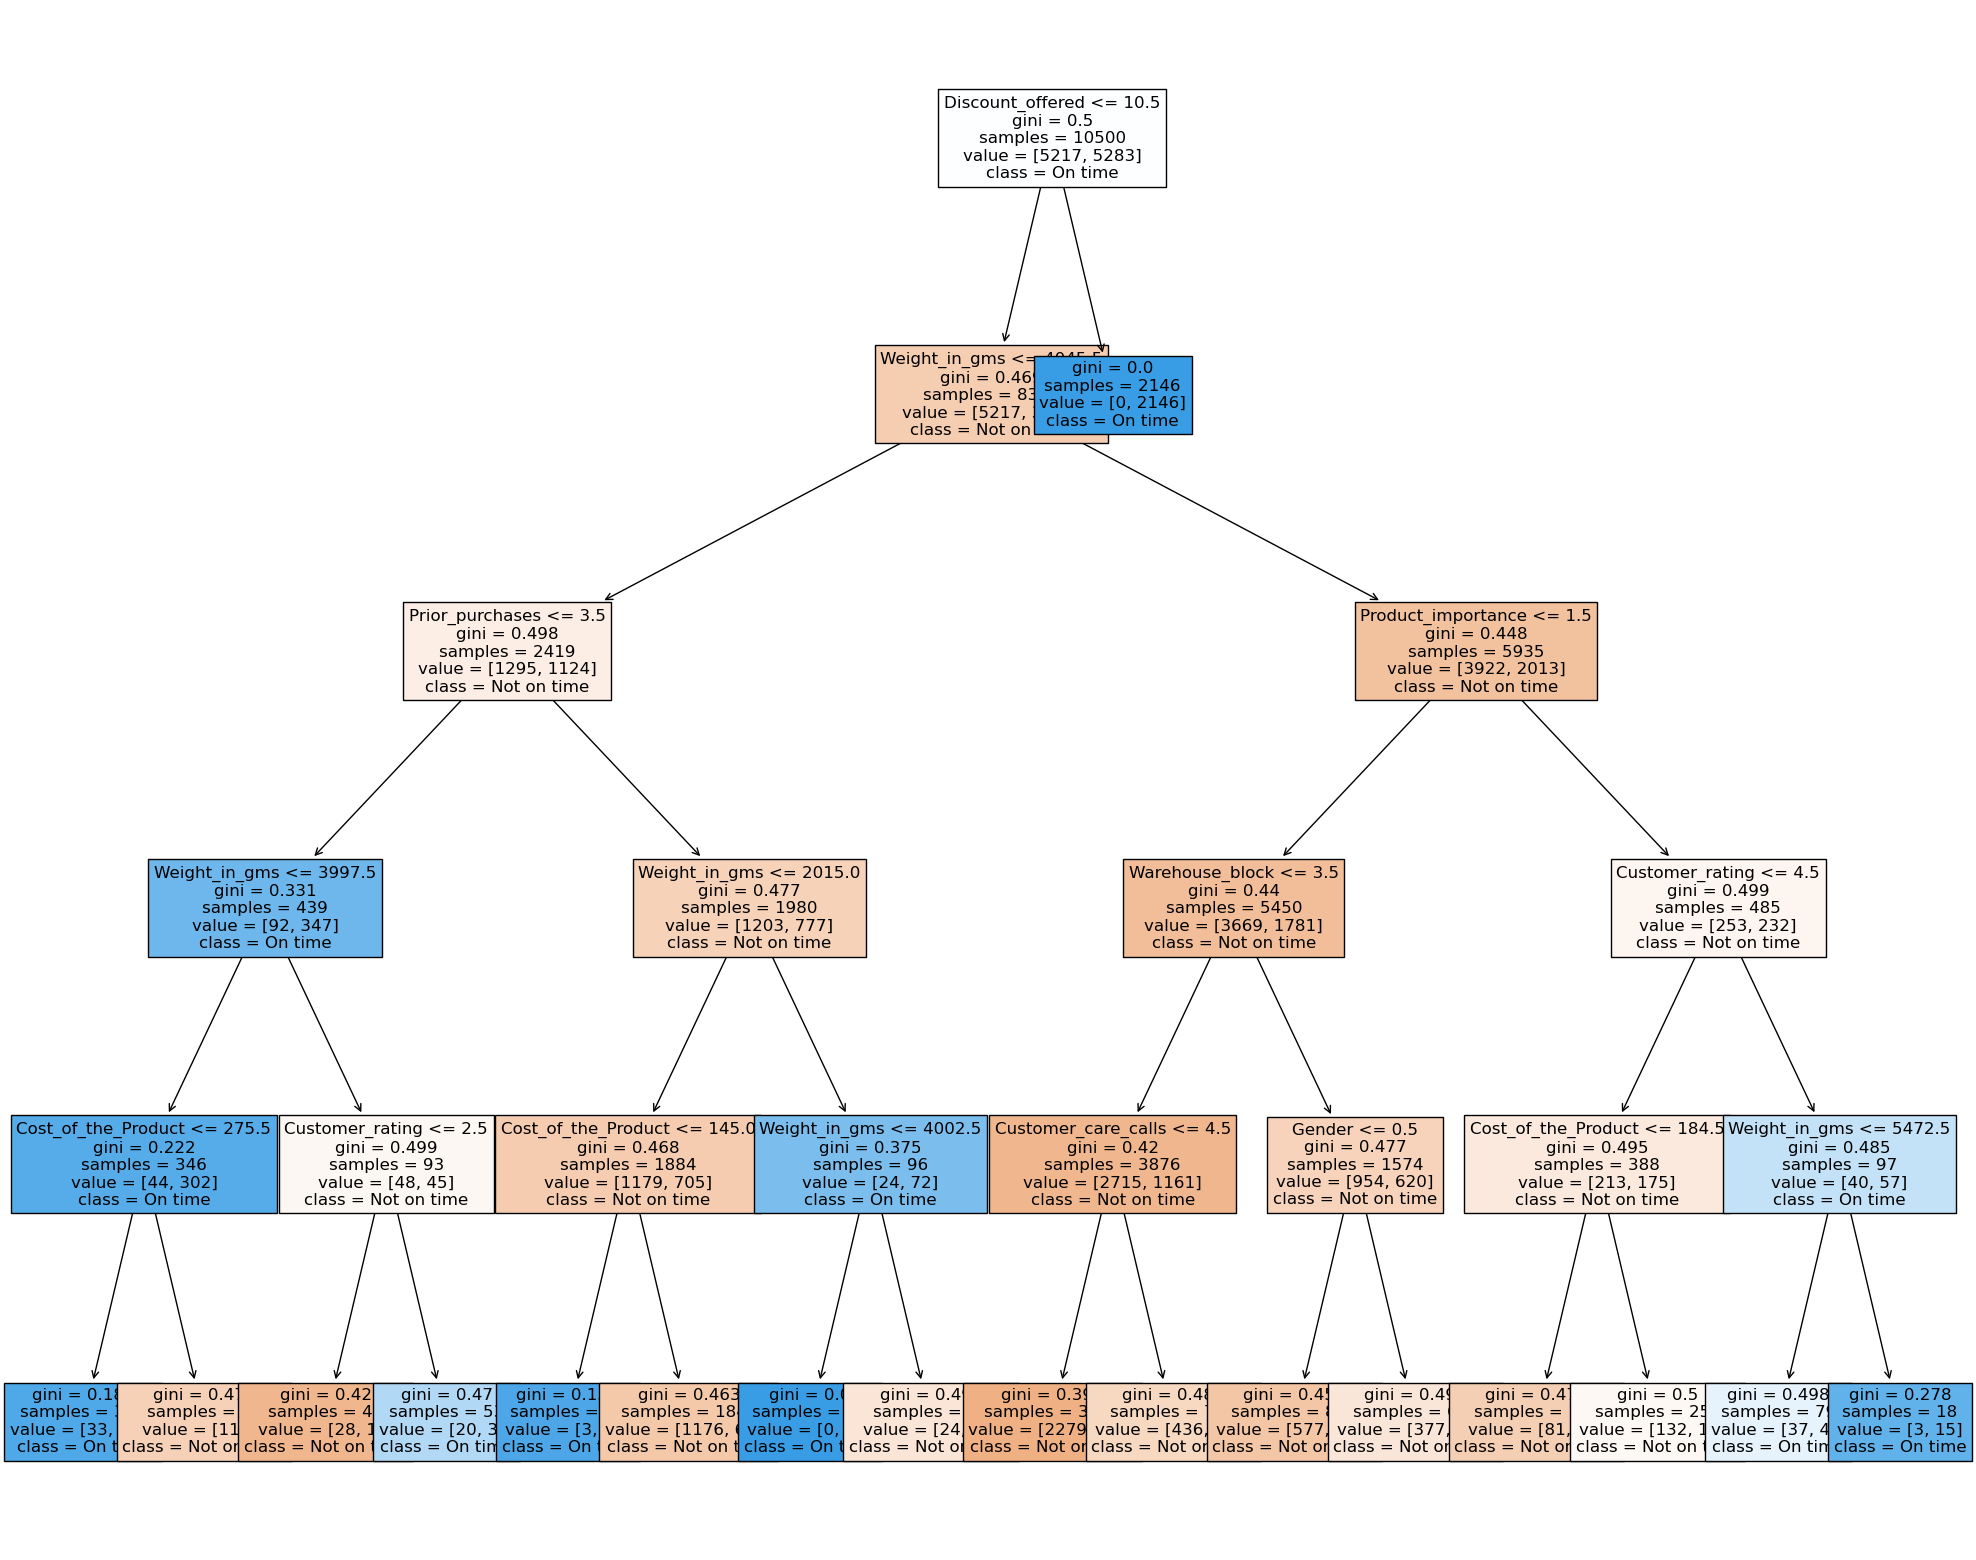

In [217]:
### print pdf:
#import graphviz 
#from sklearn import tree

#dot_data = tree.export_graphviz(clf, out_file=None) 
#graph = graphviz.Source(dot_data) 
#graph.render("eCommerce_shipping_data_DT") 

#dot_data = tree.export_graphviz(clf, out_file=None, 
#                                feature_names=feature_names,  
#                                class_names=['Not on time','On time'],  
#                                filled=True, rounded=True,  
#                                special_characters=True)  
#graph = graphviz.Source(dot_data)  

from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf,
                  feature_names = feature_names,
                  class_names = {0:'Not on time', 1:'On time'},
                  filled = True,
                  fontsize = 12)

The tree is slightly mysterious. What stands out is that already at depth 1 there is a leaf node. Now we understand why discount offered is so important: if > 10.5% discount is offered, the product will arrive on time 100% of the times. This systematic effect warrants further inquiry. Also note that discount is a decision node only at depth 0.